<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


## Build a cube

This notebook demonstrates _ITSCube_ class which is used to generate time series of velocity pair granules for the region of interest which is defined by a polygon in target UTM projection.

ITSCube:
1. Submits a query to the API to get a list of ITS_LIVE granules qualifying to be included into the cube.
   * Polygon coordinates are converted longitude/latitude coordinates to pass them as an input to API
1. Accesses ITS_LIVE granules, that are stored in AWA S3 bucket, remotely without downloading them to the local storage.
1. Ignores granules that don't contain valid data for the region of interest. It keeps track of a number of such ignored granules.
1. Ignores granules that are defined in other than a target UTM projection. It keeps track of a number of such ignored granules.


### ITSCube TODO
 * Should handle multiple granules for the same "middle date": pick the granule which has data in the target projection
 * Interpolate polygon edges to get better region inclusion it lat/lon coordinates when submitting query to the search API

In [2]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from itscube import ITSCube

# Create polygon as a square around the centroid in target '32628' UTM projection

# Centroid for the tile in target 32628 projection
c_x, c_y = (487462, 9016243)

# Offset in meters (1 pixel=240m): 24 km square (with offset=12km)
off = 120000 

# For now assume perfect rectangle
polygon = ((c_x - off, c_y - off), (c_x + off, c_y - off), (c_x + off, c_y + off), (c_x - off, c_y + off), (c_x - off, c_y - off))

# Projection for the polygon coordinates
projection = '32628'
   
cube = ITSCube(polygon, projection)

# TODO: Should have them as separate input parameters for ITSCube.create()?
API_params = {'start': '2010-01-05',
              'end':   '2020-01-01',
              'percent_valid_pixels': 1}

Longitude/latitude coords for polygon: [-21.89395598818151, 80.06086222856409, -9.401264796897465, 80.08494193632627, -7.8699075329004735, 82.22198893821736, -23.770623059922208, 82.19120200783038, -21.89395598818151, 80.06086222856409]


In [6]:
# Examine only first 100 granules - too slow to access S3 bucket locally
found_urls = cube.create(API_params, 100)

Originally found urls:  107200
Examining only 100 first granules
Skipped granules:
      empty data: 0 (0.0%)
      wrong proj: 93 (93.0%)


In [5]:
list(cube.velocities.keys())

[datetime.datetime(2016, 12, 12, 0, 0),
 datetime.datetime(2016, 12, 20, 0, 0),
 datetime.datetime(2018, 5, 1, 0, 0),
 datetime.datetime(2016, 12, 23, 0, 0),
 datetime.datetime(2017, 2, 9, 0, 0),
 datetime.datetime(2011, 6, 9, 0, 0),
 datetime.datetime(2011, 6, 24, 0, 0)]

### Examine random cube layer

In [7]:
# Examine one of the layers
first_date = list(cube.velocities.keys())[0]
first_layer = cube.velocities[first_date]
first_layer
# first_layer.x.values

<xarray.DataArray 'v' (y: 88, x: 375)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x         (x) float64 3.676e+05 3.678e+05 3.68e+05 ... 4.571e+05 4.573e+05
  * y         (y) float64 8.917e+06 8.917e+06 8.917e+06 ... 8.897e+06 8.896e+06
    mid_date  datetime64[ns] 2016-12-12
Attributes:
    units:                m/y
    standard_name:        velocity
    map_scale_corrected:  [0]
    best_practice:        velocities should always be merged/averaged using c...
    grid_mapping:         UTM_Projection
    projection:           32628
    url:                  http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/...

In [29]:
first_layer.attrs

{'units': 'm/y',
 'standard_name': 'velocity',
 'map_scale_corrected': array([0], dtype=int8),
 'best_practice': 'velocities should always be merged/averaged using component velocities to prevent high velocity magnitude bias',
 'grid_mapping': 'UTM_Projection',
 'projection': '32628',
 'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_038242_20180420_20180420_01_RT_X_LC08_L1TP_038242_20170807_20170808_01_RT_G0240V01_P049.nc'}

In [9]:
first_layer.x

<xarray.DataArray 'x' (x: 375)>
array([367552.5, 367792.5, 368032.5, ..., 456832.5, 457072.5, 457312.5])
Coordinates:
  * x         (x) float64 3.676e+05 3.678e+05 3.68e+05 ... 4.571e+05 4.573e+05
    mid_date  datetime64[ns] 2016-12-12
Attributes:
    units:          m
    standard_name:  projection_x_coordinate
    long_name:      x coordinate of projection

### Test Grid functionality
This is just a sanity check for Matlab functionality to create new grid based on a bounding box. Alex is looking into descrepancy of 7.5m.

In [16]:
from utils import Grid

# Confirm original grid spacing
values = first_layer.x.values
grid_size = values[1] - values[0]
center_off = grid_size/2

# Test Grid.bounds
# Compute cell boundaries as its_live granule stores x/y for the cell centers
xmin = first_layer.x.values.min() - center_off
xmax = first_layer.x.values.max() + center_off
ymin = first_layer.y.values.min() - center_off
ymax = first_layer.y.values.max() + center_off

x0_min, x0_max, y0_min, y0_max = Grid.bounds(xmin, xmax, ymin, ymax, grid_size)
"Original coords: ", xmin, xmax, ymin, ymax
"New coords:      ", x0_min, x0_max, y0_min, y0_max
"Difference: ", xmin - x0_min, xmax - x0_max, ymin - y0_min, ymax - y0_max

('Original coords: ', 367432.5, 457432.5, 8896327.5, 8917447.5)

('New coords:      ', 367200.0, 457440.0, 8896320.0, 8917680.0)

('Difference: ', 232.5, -7.5, 7.5, -232.5)

In [17]:
x0, y0 = Grid.create_grid(first_layer.x.values.min(), first_layer.x.values.max(), first_layer.y.values.min(), first_layer.y.values.max(), 240)

"Original: ", first_layer.x.values[:10], " len: ", len(first_layer.x.values)
"New grid: ", x0[:10], " len: ", len(x0)

('Original: ',
 array([367552.5, 367792.5, 368032.5, 368272.5, 368512.5, 368752.5,
        368992.5, 369232.5, 369472.5, 369712.5]),
 ' len: ',
 375)

('New grid: ',
 array([367560., 367800., 368040., 368280., 368520., 368760., 369000.,
        369240., 369480., 369720.]),
 ' len: ',
 375)

### Display cube layers

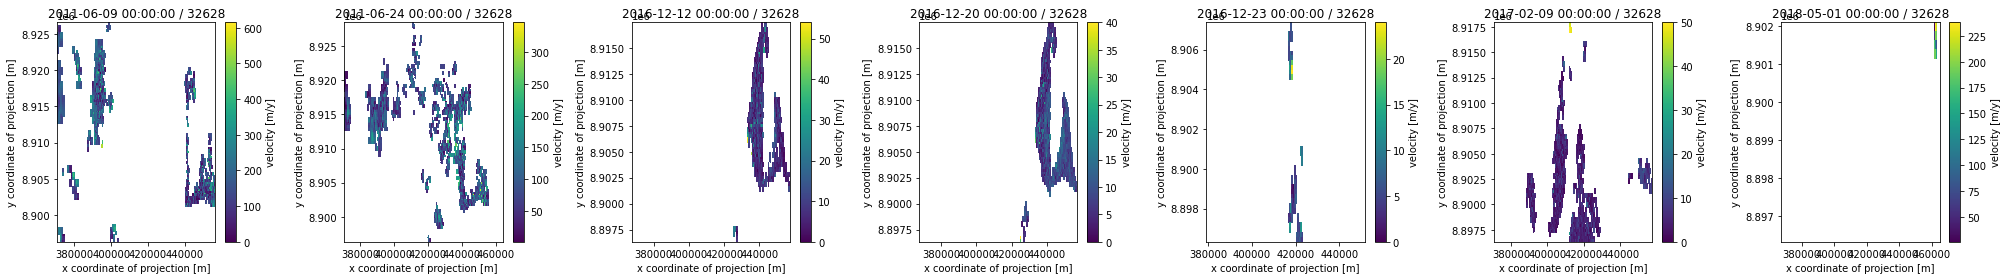

In [14]:
# cube.plot_layers()
cube.plot_num_layers(7)

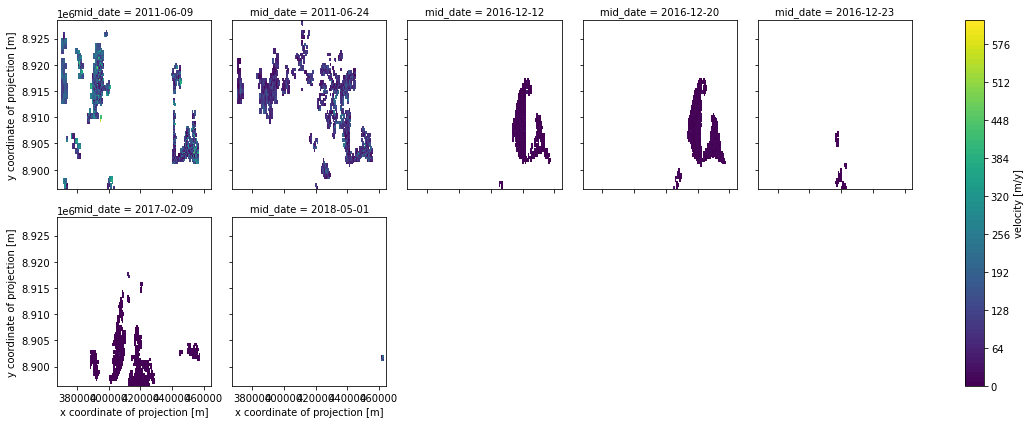

In [15]:
cube.plot()